# Full Train Workflow

Run when you need to train a new classifier from scratch. Will regenerate transient data, refit all samples, and retrain the classifier.

## Step 0: Update configuration file.

In the same folder as this notebook, there is a $\texttt{config.yaml}$ file, which contains all filepaths and configuration options for the training workflow. Please update this now!

The most important filepath arguments are:
* $\texttt{create_dirs}$: Probably keep set to True. Create any data subdirectories that are missing.
* $\texttt{data_dir}$: This is where all generated data is stored. Set to the root directory for all outputs.
* $\texttt{relative_dirs}$: If true, all data for each step is stored within subdirectories of data_dir.
* $\texttt{transient_data_fn}$: This is where all transient data is stored as a TransientGroup. Technically a directory but loaded as a single file. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{sampler_results_fn}$: Where light curve fits are stored. If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{figs_dir}$: Where all figures are stored (only generated if $\texttt{plot}$ is set to True). If relative_dirs is True, is created as a subdirectory of data_dir.
* $\texttt{models_dir}$: Where all classification models are stored. If relative_dirs is True, is created as a subdirectory of data_dir.

The most important sampling and classifier arguments are:
* $\texttt{sampler}$: Set to either dynesty or svi (all lowercase). SVI is faster but forces the posterior into a multivariate Gaussian.
* $\texttt{model_type}$: Set to either LightGBM (recommended) or MLP.
* $\texttt{use_redshift_features}$: If True, includes peak absolute magnitude and redshift as training features.
* $\texttt{fits_per_majority}$: Oversamples such that the majority class has this many samples fed into the classifier. Minority classes will correspond to more input samples per event. Defaults to 5.
* $\texttt{target_label}$: For binary classification - this is the positive label. Set to None for multiclass classification.
* $\texttt{n_folds}$: Number of K-folds. I usually set to 10.
* $\texttt{num_epochs}$: Number of estimators for LightGBM or number of training epochs for MLP.
* $\texttt{n_parallel}$: Number of threads to parallelize data import + sampling over.
* $\texttt{random_seed}$: For reproducibility.

## Step 1: Generate new TransientSet

Here we will import data from TNS + ALeRCE and generate a new TransientSet, from a list of event names. Names can be from TNS or ZTF.

The below code block will retrieve all spectroscopically classified TNS transients. Feel free to change to your own list of names or import script.

In [1]:
from snapi.query_agents import TNSQueryAgent
tns_agent = TNSQueryAgent()
all_names = tns_agent.retrieve_all_names() # only spectroscopically classified
print(len(all_names), all_names[:5])

16167 ['2024iro' '2024hun' '2024iyu' '2024imo' '2024ier']


The following script will import data for all provided names and generate a TransientGroup object. Will run in parallel across n_cores threads.

In [2]:
import os, glob, shutil

from superphot_plus.config import SuperphotConfig
from superphot_plus.data_generation import import_all_names

config = SuperphotConfig.from_file("config.yaml")
save_dir = config.transient_data_fn

# import data for all_names from query agents
import_all_names(
    all_names, save_dir,
    checkpoint_freq=1024,
    n_cores=config.n_parallel,
    overwrite=False
) # set overwrite=False to continue from where left off

2024-12-03 15:13:01.946477: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 15:13:05.105023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733256785.968009 2294705 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733256786.218917 2294705 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 15:13:09.013019: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

14589 names to query across 8 cores.
Processing 1043 transients in batch
Finished processing, making transient group now
Total transients saved: 1700.
Processing 1042 transients in batch


Finished processing, making transient group now
Total transients saved: 2158.
Processing 1042 transients in batch
Finished processing, making transient group now
Total transients saved: 2596.
Processing 1042 transients in batch


Finished processing, making transient group now
Total transients saved: 3054.
Processing 1042 transients in batch
Finished processing, making transient group now
Total transients saved: 3496.
Processing 1042 transients in batch


Finished processing, making transient group now
Total transients saved: 3904.
Processing 1042 transients in batch


Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/n/holylabs/LABS/avillar_lab/Users/kdesoto/conda_envs/snapi_env/lib/python3.11/site-packages/astropy/units/format/generic.py", line 585, in _do_parse
    return cls._parse_unit(s, detailed_exception=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/n/holylabs/LABS/avillar_lab/Users/kdesoto/conda_envs/snapi_env/lib/python3.11/site-packages/astropy/units/format/generic.py", line 585, in _do_parse
    return cls._parse_unit(s, detailed_exception=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/n/holylabs/LABS/avillar_lab/Users/kdesoto/conda_envs/snapi_env/lib/python3.11/site-packages/astropy/units/format/generic.py", line 481, in _parse_unit
    raise ValueError()

KeyboardInterrupt: 

In [3]:
# Let's check the TransientGroup we created!
from snapi import TransientGroup
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)

print(len(transient_group.metadata))
print(transient_group.metadata.head())

3904
                 ra        dec            internal_names spec_class  redshift
id                                                                           
2016dto  261.583750   6.271917   ZTF18ablwqqf, Gaia16agr    Varstar     0.000
2016ewr  275.658571  12.438262   ZTF18abnvuya, kait-16au         CV       NaN
2016jam  319.925941  24.508384  ATLAS16ebw, ZTF18acegjxo         CV       NaN
2017bcc  172.970782  29.995785     PS17bgn, ZTF20aacbwbm    SLSN-II     0.148
2017fom    7.384708  50.431719   Gaia17btz, ZTF18abktleu         CV       NaN


Finally, before fitting, we want to phase and normalize all the photometry. This is because our samplers expect light curves to already be phased and normalized before fitting.

In [5]:
from snapi import TransientGroup
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
new_transients = []
for i, t in enumerate(transient_group):
    if i % 1000 == 0:
        print(f"Preprocessed {i} out of {len(transient_group)} transients.")
    t.photometry.phase(inplace=True)
    t.photometry.normalize(inplace=True)
    new_transients.append(t)

new_transient_group = TransientGroup(new_transients)
new_transient_group.save(config.transient_data_fn)

Preprocessed 0 out of 3904 transients.
Preprocessed 1000 out of 3904 transients.
Preprocessed 2000 out of 3904 transients.
Preprocessed 3000 out of 3904 transients.


## Step 2 (Option 1): Fit all transients using SVI (faster)

Here, we choose to fit our transients using stochastic variational inference (SVI). If using this option, make sure sampler='superphot_svi' in the config.yaml file. This option is faster but assumes Gaussianity of the posterior space, which can be limiting for certain light curve fits.

In [1]:
import os
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

result = fit_transient_group(
    transient_group,
    sampler = svi_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = config.sampler_results_fn,
    checkpoint_freq = 512,
    pad=True
)
SamplerResultGroup(result).save(config.sampler_results_fn)

E0000 00:00:1733260524.513985 2336793 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733260524.706403 2336793 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 16:15:45,417 - MainProcess - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-03 16:15:45,967 - MainProcess - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Transient group loaded


[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()
[INFO/MainProcess] child process calling self.run()


KeyboardInterrupt: 

        A_ZTF_r_median  beta_ZTF_r_median  gamma_ZTF_r_median  \
id                                                              
2024ws        1.583780           0.004587          108.388367   
2024xh        0.983467           0.009626           21.645714   
2024xx        1.056682           0.004683           16.509243   
2024ym        1.189234           0.005576            9.680868   
2024yr        1.188248           0.009824           11.836633   

        t_0_ZTF_r_median  tau_rise_ZTF_r_median  tau_fall_ZTF_r_median  \
id                                                                       
2024ws        -15.159479              40.174187              20.708725   
2024xh        -11.533133               0.962603              42.910679   
2024xx        -16.489235               3.931556              29.413177   
2024ym         -9.013236               2.761401              25.481071   
2024yr        -15.494478               1.294959              49.303398   

        extra_sigma_ZTF_r

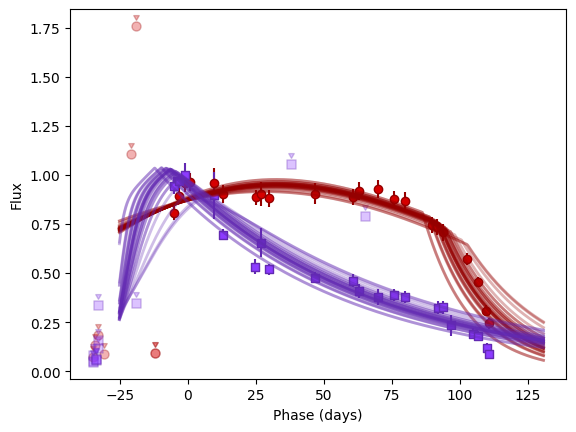

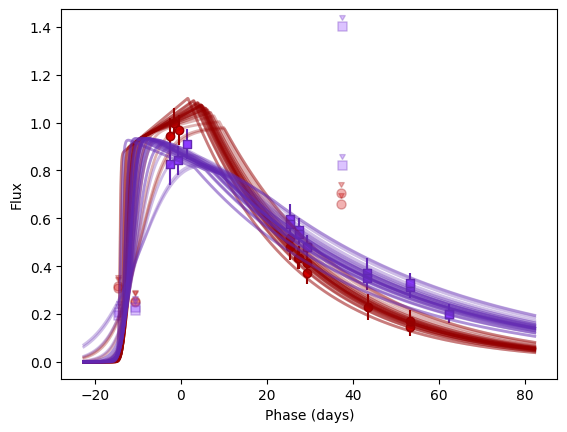

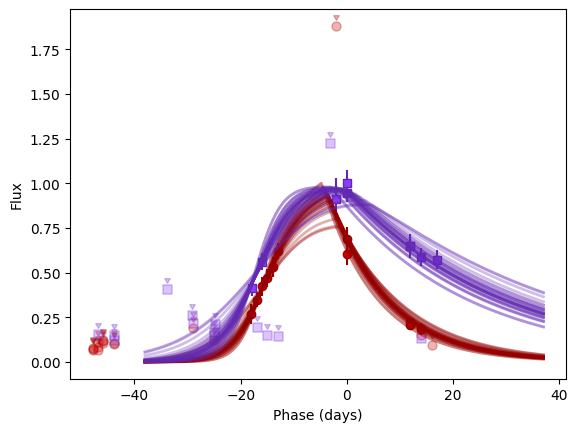

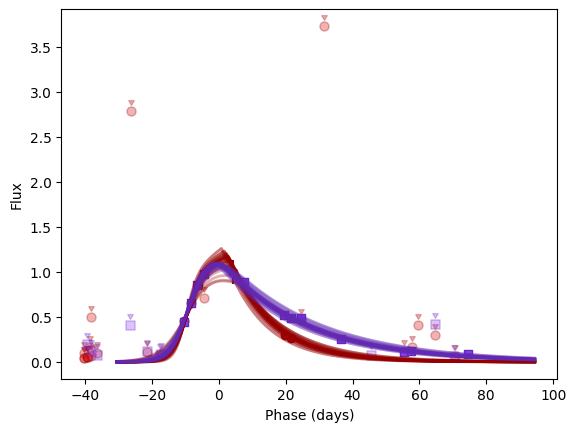

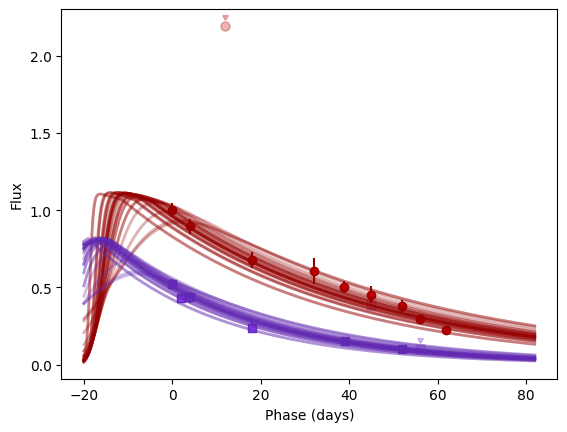

In [3]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.numpyro_sampler import SVISampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(config.sampler_results_fn)

priors = generate_priors(["ZTF_r","ZTF_g"])
svi_sampler = SVISampler(
    priors=priors,
    num_iter=10_000,
    random_state=config.random_seed,
)

formatter = Formatter()
for n in names[-5:]: # neweet 
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    
    plt.show()
    

## Step 2 (Option 2): Fit light curves using dynesty (slower)

Here, we fit our transient photometry using the dynesty nested sampler. This is slower but does not assume Gaussianity of the posterior space, so can better capture degeneracies between parameters. If you use this, make sure to set sampler=superphot_dynesty in the config.yaml file.

In [4]:
import os
from snapi.scripts import fit_transient_group
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus.samplers.dynesty_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

transient_group = TransientGroup.load(config.transient_data_fn)
print("Transient group loaded")

priors = generate_priors(["ZTF_r","ZTF_g"])

dynesty_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

result = fit_transient_group(
    transient_subgroup,
    sampler = dynesty_sampler,
    parallelize=True,
    n_parallel=config.n_parallel,
    checkpoint_fn = config.sampler_results_fn,
    checkpoint_freq = 128,
    pad=False
)
SamplerResultGroup(result).save(config.sampler_results_fn)


322 ['2016cya' '2016dto' '2016ewr' '2016hvq' '2016jam']
Transient group loaded
322


/n/holylabs/LABS/avillar_lab/Users/kdesoto/conda_envs/snapi_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(


         A_ZTF_r_median  beta_ZTF_r_median  gamma_ZTF_r_median  \
id                                                               
2024iyu        1.243404           0.012271           42.713496   
2024mq         1.403090           0.000601            6.872997   
2024os         1.733937          -0.000505            4.299315   
2024wp         1.681376           0.002745           59.689066   
2024yr         1.141421           0.001126           17.353774   

         t_0_ZTF_r_median  tau_rise_ZTF_r_median  tau_fall_ZTF_r_median  \
id                                                                        
2024iyu        -21.369028               5.690106              10.877397   
2024mq           1.766995              15.143172              11.484284   
2024os          -0.641352              12.177634              16.024021   
2024wp          -8.301929              58.884010              39.140034   
2024yr         -18.240565               1.657004              40.168699   

         ex

/n/holylabs/LABS/avillar_lab/Users/kdesoto/conda_envs/snapi_env/lib/python3.11/site-packages/dynesty/dynamicsampler.py:530: RuntimeWarning: All the initial likelihood values are the same. You likely have a plateau in the likelihood. Nested sampling may not be the best sampler in this case.
  warnings.warn(


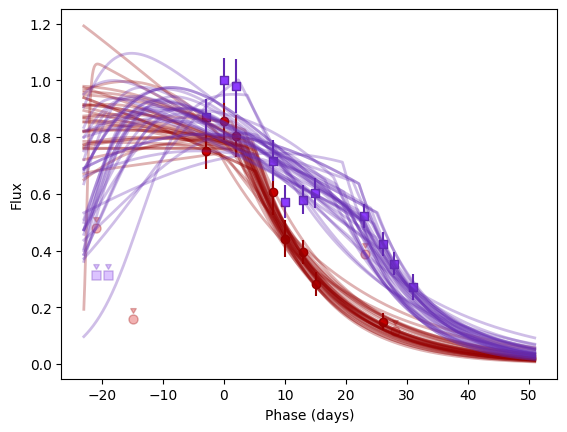

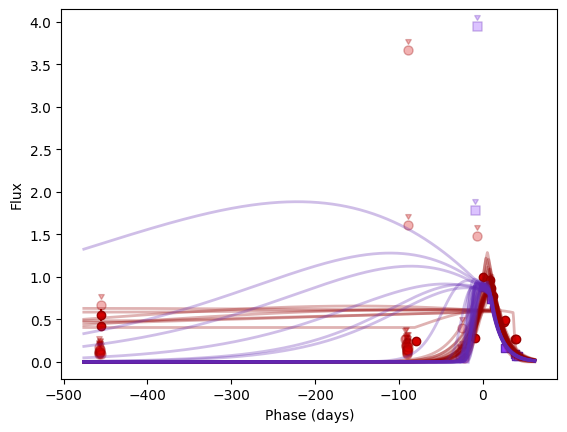

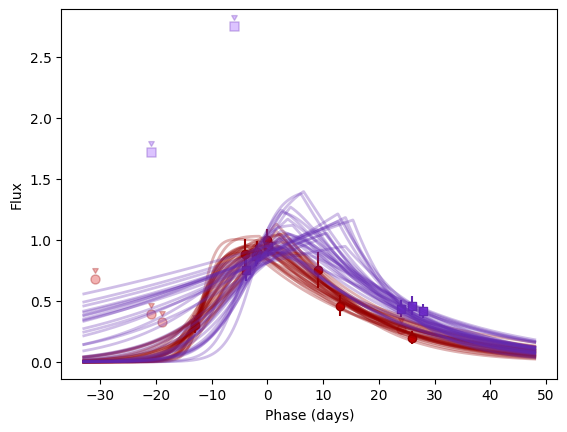

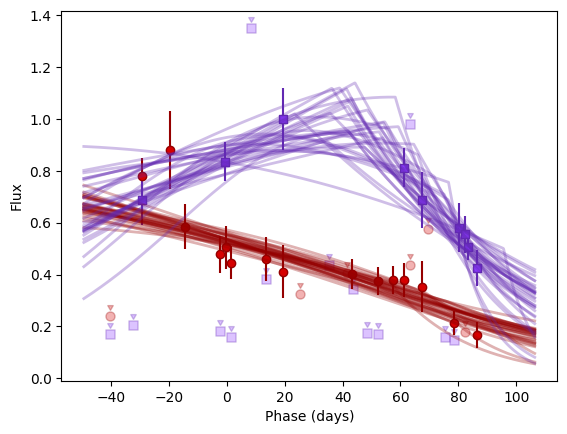

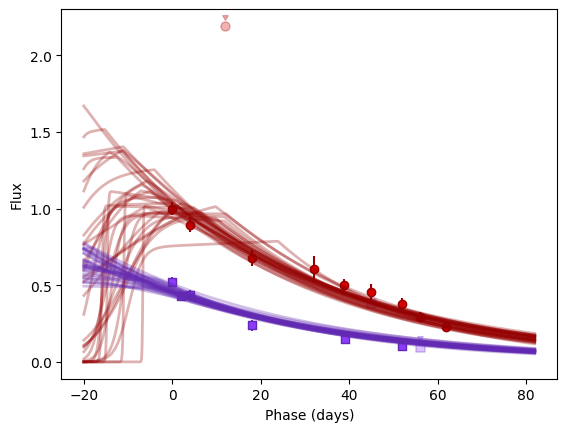

In [6]:
# sanity check plot
import os
import matplotlib.pyplot as plt

from snapi import TransientGroup, SamplerResultGroup, Formatter
from superphot_plus.samplers.numpyro_sampler import DynestySampler
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")
transient_group = TransientGroup.load(config.transient_data_fn)
sampler_results = SamplerResultGroup.load(config.sampler_results_fn)

priors = generate_priors(["ZTF_r","ZTF_g"])

svi_sampler = DynestySampler(
    priors=priors,
    random_state=config.random_seed,
)

formatter = Formatter()
for n in names[-5:]: # neweet 
    t = transient_group[n] # can index like dictionary
    sr = sampler_results[n]
    svi_sampler.load_result(sr)
    
    fig, ax = plt.subplots()
    svi_sampler.plot_fit(
        ax,
        photometry = t.photometry,
        formatter = formatter,
    )
    t.photometry.plot(
        ax,
        mags=False,
        formatter=formatter
    )
    formatter.make_plot_pretty(ax)
    formatter.add_legend(ax)
    
    plt.show()
    

## Step 2.5: Convert SamplerResultGroup posteriors back to uncorrelated Gaussians

When sampling, the posteriors are saved as the inputs to our flux model. The Gaussian priors, however, were converted to log-Gaussians and multiplied by base parameters where necessary before being fed into the model function. Therefore, we must revert these log-Gaussian and relative parameters back to their original uncorrelated Gaussian draws before using as classifier inputs. We do this below:

In [1]:
import os
from snapi import SamplerResultGroup
from superphot_plus.priors import generate_priors
from superphot_plus.config import SuperphotConfig

config = SuperphotConfig.from_file("config.yaml")

priors = generate_priors(["ZTF_r","ZTF_g"])
sampler_results = SamplerResultGroup.load(config.sampler_results_fn)

new_sr = []
for i, sr in enumerate(sampler_results):
    if i % 1000 == 0:
        print(f"Converted {i} out of {len(sampler_results)} fits")
    columns = sr.fit_parameters.columns
    columns = columns[columns != 'score']
    sr.fit_parameters.loc[:, columns] = priors.reverse_transform(sr.fit_parameters.loc[:, columns])
    new_sr.append(sr)
    
new_sampler_results = SamplerResultGroup(new_sr)
new_sampler_results.save(config.sampler_results_fn)


## Step 3: Train classifier from sampling posteriors

Here we train a classifier with our uncorrelated posterior features. This script will automatically split the data into K-folds, oversample the training and validation sets to even out minority classes, and train either LightGBMs (recommended) or MLPs. If plot is True, metric plots and confusion matrices will also be generated.

In [1]:
import os
from snapi import TransientGroup, SamplerResultGroup
from superphot_plus import SuperphotConfig, SuperphotTrainer

config = SuperphotConfig.from_file("config.yaml")
trainer = SuperphotTrainer(config)
trainer.run()

2024-12-03 13:42:19.539605: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 13:42:19.560311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733251339.582091 2052653 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733251339.588977 2052653 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 13:42:19.614284: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

NameError: name 'path' is not defined